# Kevitsa VTEM 

In [1]:
from SimPEG import Mesh, EM, Utils, Maps
%pylab inline
import numpy as np
from scipy.constants import mu_0
from ipywidgets import interact, IntSlider

Populating the interactive namespace from numpy and matplotlib


## Model

In [2]:
sig_halfspace = 2e-3
sig_target = 0.1
sig_air = 1e-8
times = np.logspace(-4, -2, 21)
def diffusion_distance(sigma, time):
    return 1.28*np.sqrt(time/(sigma * mu_0))

print(
    'min diffusion distance: {:.2e} m'.format(diffusion_distance(sig_halfspace, times.min()))
)
print(
    'max diffusion distance: {:.2e} m'.format(diffusion_distance(sig_halfspace, times.max()))
)

min diffusion distance: 2.55e+02 m
max diffusion distance: 2.55e+03 m


## Mesh

In [3]:
# x-direction
csx = 20  # core mesh cell width in the x-direction
ncx = 20
npadx = 15  # number of x padding cells

# z-direction
csz = 20  # core mesh cell width in the z-direction
ncz = 40
npadz = 15  # number of z padding cells

# padding factor (expand cells to infinity)
pf = 1.3

# cell spacings in the x and z directions
hx = Utils.meshTensor([(csx, ncx), (csx, npadx, pf)])
hz = Utils.meshTensor([(csz, npadz, -pf), (csz, ncz), (csz, npadz, pf)])

# define a SimPEG mesh
mesh = Mesh.CylMesh([hx, 1, hz], x0 ="00C")

The maximum diffusion distance (in background) is: 2.55e+03 m. Does the mesh go sufficiently past that?


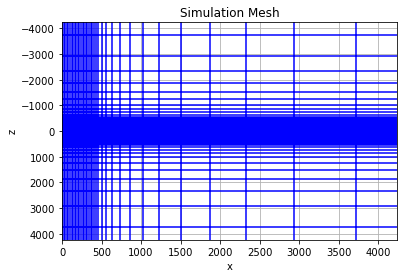

In [4]:
# X and Z limits we want to plot to. Try 
xlim = np.r_[0., mesh.vectorCCx.max()]
zlim = np.r_[mesh.vectorCCz.max(), mesh.vectorCCz.min()]

fig, ax = plt.subplots(1,1)
mesh.plotGrid(ax=ax)

ax.set_title('Simulation Mesh')
ax.set_xlim(xlim)
ax.set_ylim(zlim)

print(
    'The maximum diffusion distance (in background) is: {:.2e} m. '
    'Does the mesh go sufficiently past that?'.format(
        diffusion_distance(sig_halfspace, times.max())
    )
)

Next, we put the model on the mesh

In [13]:
# create a vector that has one entry for every cell center
sigma = sig_air*np.ones(mesh.nC)  # start by defining the conductivity of the air everwhere
sigma[mesh.gridCC[:,2] < 0.] = sig_halfspace  # assign halfspace cells below the earth
sigma_background = sigma.copy()
sigma_layer = sigma.copy()
radius = 150.
# indices of the sphere (where (x-x0)**2 + (z-z0)**2 <= R**2)
layer_ind = np.logical_and(mesh.gridCC[:,2]>-300, mesh.gridCC[:,2]<-200)
blk_ind = (mesh.gridCC[:,0] < radius) & layer_ind
sigma[blk_ind] = sig_target  # assign the conductivity of the sphere
sigma_layer[layer_ind] = sig_target  # assign the conductivity of the sphere

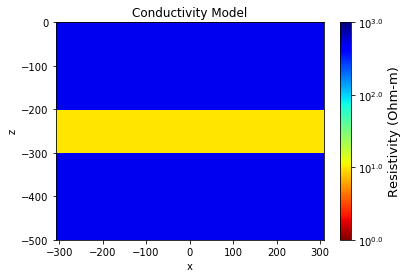

In [14]:
plt.set_cmap(plt.get_cmap('jet_r'))
# Plot a cross section of the conductivity model
fig, ax = plt.subplots(1,1)
out = mesh.plotImage(np.log10(1./sigma_layer), ax=ax, mirror=True, clim=(0, 3), grid=False)
cb = plt.colorbar(out[0], ticks=np.linspace(0,3,4), format="10$^{%.1f}$")
# plot formatting and titles
cb.set_label('Resistivity (Ohm-m)', fontsize=13)
ax.axis('equal')
ax.set_xlim([-120., 120.])
ax.set_ylim([-500., 0.])
ax.set_title('Conductivity Model')

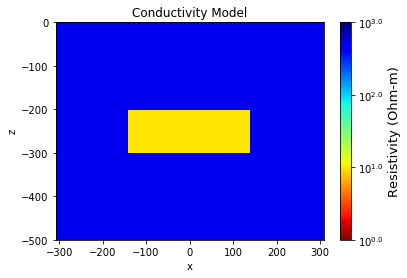

In [15]:
# Plot a cross section of the conductivity model
fig, ax = plt.subplots(1,1)
out = mesh.plotImage(np.log10(1./sigma), ax=ax, mirror=True, clim=(0, 3), grid=False)
# plot formatting and titles
cb = plt.colorbar(out[0], ticks=np.linspace(0,3,4), format="10$^{%.1f}$")
# plot formatting and titles
cb.set_label('Resistivity (Ohm-m)', fontsize=13)
ax.axis('equal')
ax.set_xlim([-120., 120.])
ax.set_ylim([-500., 0.])
ax.set_title('Conductivity Model')

## Forward Simulation 

- Define the receivers, we will sample the real secondary magnetic flux density as well as the imaginary magnetic flux density

In [16]:
rx_loc = np.array([[0., 0., 41.]])
src_loc = np.array([[0., 0., 41.]])
offTime = 0.007307
peakTime = 0.006
a = 3.
dbdt_z = EM.TDEM.Rx.Point_dbdt(locs=rx_loc, times=times+offTime, orientation='z')  # vertical db_dt
rxList = [dbdt_z]  # list of receivers
srcList = [
    EM.TDEM.Src.CircularLoop(
        rxList, loc=src_loc, radius=13., orientation='z', waveform=EM.TDEM.Src.VTEMWaveform(offTime=offTime, peakTime=peakTime, a=3.)
    )
]

In [17]:
# solve the problem at these times
timeSteps = [(peakTime/5, 5), ((offTime-peakTime)/5, 5), (1e-5, 10), (5e-5, 10), (1e-4, 10), (5e-4, 19)] 
prob = EM.TDEM.Problem3D_b(mesh, timeSteps = timeSteps, sigmaMap=Maps.IdentityMap(mesh))  
survey = EM.TDEM.Survey(srcList)
prob.pair(survey)  

In [18]:
src = srcList[0]
rx = src.rxList[0]
wave = []
for time in prob.times:
    wave.append(src.waveform.eval(time))
wave = np.hstack(wave)

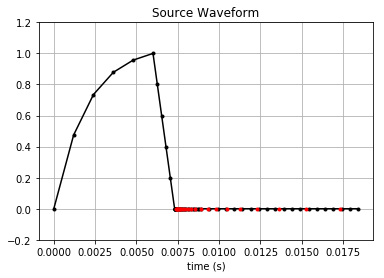

In [19]:
plt.plot(prob.times, wave, 'k.-')
plt.plot(rx.times, np.zeros_like(rx.times), 'r.')
plt.ylim(-0.2, 1.2)
plt.grid(True)
plt.title('Source Waveform')
plt.xlabel('time (s)')

## Compute Predicted Data

In [20]:
d_background = survey.dpred(sigma_background)
d_layer = survey.dpred(sigma_layer)
d = survey.dpred(sigma)

In [21]:
f_layer = prob.fields(sigma_layer)

### Electric field in the layer model

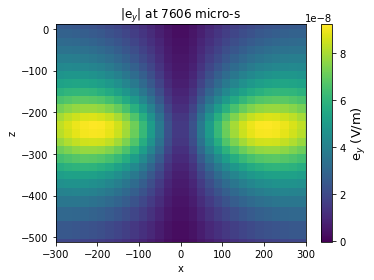

In [22]:
plt.set_cmap(plt.get_cmap('viridis'))
def vizfield_layer(itime):
    fig = plt.figure(figsize = (7*0.8,5*0.8))
    ax = plt.subplot(111)
    cb = plt.colorbar(mesh.plotImage(mesh.aveE2CC*f_layer[src, 'e', itime], ax=ax, mirror=True)[0])
    # plot formatting and titles
    cb.set_label('e$_{y}$ (V/m)', fontsize=13)
    ax.axis('equal')
    ax.set_xlim([-300., 300.])
    ax.set_ylim([-500., 0.])
    ax.set_title(('|e$_{y}$| at %d micro-s')%(prob.times[itime]*1e6))
    plt.show()
interact(vizfield_layer, itime=IntSlider(min=0, max=len(prob.times)-1, step=1, value=11))

### Electric Field in the Cylinder model

In [25]:
f = prob.fields(sigma)

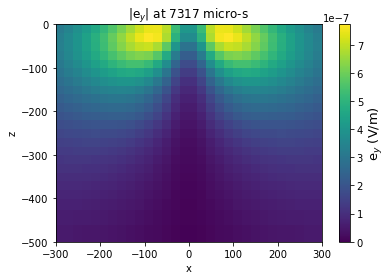

<function __main__.vizfield_cylinder>

In [26]:
def vizfield_cylinder(itime):
    fig = plt.figure(figsize = (7*0.8,5*0.8))
    ax = plt.subplot(111)
    cb = plt.colorbar(mesh.plotImage(mesh.aveE2CC*f[src, 'e', itime], ax=ax, mirror=True)[0])
    # plot formatting and titles
    cb.set_label('e$_{y}$ (V/m)', fontsize=13)
#     ax.axis('equal')
    ax.set_xlim([-300., 300.])
    ax.set_ylim([-500., 0.])
    ax.set_title(('|e$_{y}$| at %d micro-s')%(prob.times[itime]*1e6))
    plt.tight_layout()
    plt.show()
interact(vizfield_cylinder, itime=IntSlider(min=0, max=len(prob.times)-1, step=1, value=11))    

In [28]:
area = 13**2*np.pi 

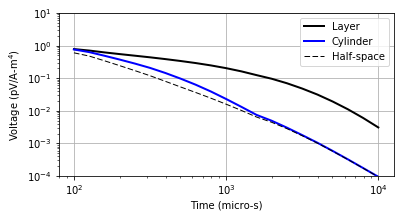

In [29]:
figsize(6, 3)
plt.loglog((rx.times-offTime)*1e6, -d_layer*1e12/area, 'k', lw=2)
plt.loglog((rx.times-offTime)*1e6, -d*1e12/area , 'b', lw=2)
plt.loglog((rx.times-offTime)*1e6, -d_background*1e12/area, 'k--', lw=1)

plt.xlabel("Time (micro-s)")
plt.ylabel("Voltage (pV/A-m$^4$)")
plt.legend(("Layer", "Cylinder","Half-space"), loc=1, fontsize = 10)
plt.ylim(1e-4, 1e1)
plt.grid(True)